In [1]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import math

user='r.valeev'
password='epF8hJoAV80V'
host='10.250.201.241'
dbname='dwh'

engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{dbname}')
Session = sessionmaker(bind=engine)  # sessions factory ()

def execute(SQL):
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

#### импорт данных

In [2]:
SQL = '''
SELECT *
FROM sandbox.valeev_ab_users_v2_honorary
'''

df=execute(SQL)

In [ ]:
# control_A.to_csv('control_A.csv', index=False)

In [ ]:
# df = pd.read_csv('/Users/r.valeev/Documents/аб тесты/control_A.csv')

In [179]:
df.shape

(189741, 28)

In [3]:
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = df[col].astype('float64')

In [4]:
quantiles = [50, 75, 80, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
columns = ['broadcast_per_day', 'timespent_per_day', 'cnt_watch', 'cnt_watched',
           'comment_rate', 'like_rate', 'watch_rate', 'watched_rate']


# пустой df для хранения результатов
quantiles_data = pd.DataFrame(index=quantiles, columns=columns)

for column in columns:
    data = df[column].astype(float).dropna()
    quantile_values = np.percentile(data, quantiles)
    quantiles_data[column] = quantile_values

quantiles_data

,broadcast_per_day,timespent_per_day,cnt_watch,cnt_watched,comment_rate,like_rate,watch_rate,watched_rate
50,24.500,249.0,14.0,6.0,0.000000,0.000000,0.500000,0.215686
75,42.125,493.0,25.0,12.0,0.000000,0.000000,0.846154,0.461538
80,43.000,587.0,32.0,16.0,0.000000,0.000000,0.900000,0.545455
85,44.000,702.0,40.0,24.0,0.000000,0.000000,0.955556,0.636364
90,47.000,892.5,49.0,38.0,0.000000,0.000000,1.000000,0.777778
91,48.000,957.0,52.0,38.0,0.000000,0.005862,1.000000,0.818182
92,50.000,1036.0,57.0,39.0,0.000000,0.017857,1.000000,0.865385
93,55.000,1138.0,63.0,40.0,0.000000,0.030011,1.000000,0.901961
94,61.000,1257.0,71.0,42.0,0.000000,0.045455,1.000000,0.928571
95,68.000,1402.0,82.0,44.0,0.000000,0.066116,1.000000,0.950000


In [5]:
percentile_98 = quantiles_data.loc[98]

condition = (df['broadcast_per_day'] < percentile_98['broadcast_per_day']) & \
            (df['comment_rate'] < percentile_98['comment_rate']) & \
            (df['timespent_per_day'] < percentile_98['timespent_per_day']) & \
            (df['like_rate'] < percentile_98['like_rate']) & \
            (df['watch_rate'] <= 1 & \
            (df['watched_rate'] <= 1))

df_wo_outlier = df[condition]

In [6]:
df_wo_outlier.shape

(176607, 28)

In [7]:
df[['cnt_watch', 'cnt_visible']].describe()

,cnt_watch,cnt_visible
count,189741.000000,189741.000000
mean,27.821409,51.849816
std,58.799249,100.855665
min,0.000000,1.000000
25%,10.000000,21.000000
50%,14.000000,42.000000
75%,25.000000,48.000000
max,2807.000000,8410.000000


In [8]:
df_wo_outlier[['cnt_watch', 'cnt_visible']].describe()

,cnt_watch,cnt_visible
count,176607.000000,176607.000000
mean,22.018923,42.647879
std,28.172485,43.290374
min,0.000000,3.000000
25%,10.000000,21.000000
50%,14.000000,42.000000
75%,23.000000,47.000000
max,906.000000,1015.000000


In [9]:
control_A=df_wo_outlier[df_wo_outlier['experiment_group']=='honorary_viewer_start_A']
control_D=df_wo_outlier[df_wo_outlier['experiment_group']=='honorary_viewer_start_D']

test_B=df_wo_outlier[df_wo_outlier['experiment_group']=='honorary_viewer_start_B']
test_C=df_wo_outlier[df_wo_outlier['experiment_group']=='honorary_viewer_start_C']

#### Необходимые функции

In [10]:
# расчет MDE

alpha = 0.05                   
beta = 0.2       

# sample_size = len(control_A['cnt_watch'])
# std = control_A['cnt_watch'].std()
# mu_control = control_A['cnt_watch'].mean()

def calculate_mde(sample_size, std, mu_control, alpha, beta): 
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)   
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)         
    var = 2 * std ** 2
    mde_absolute = math.sqrt((t_alpha + t_beta) ** 2 * var / sample_size)
    mde_relative = mde_absolute / mu_control * 100
    return mde_absolute, mde_relative


# mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
# print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
# print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

In [360]:
# симуляция экспериментов

def simulation(values, visible_values, sample_size, effect=0, n_iter=3000):
    pvalues = []
    
    for i in tqdm(range(n_iter)):
        num_event_a = np.random.choice(values, size=sample_size)
        visible_a = np.random.choice(visible_values, size=sample_size)

        num_event_b = np.random.choice(values, size=sample_size)
        num_event_b *= (1 + effect)     # num_event_b += effect 
        visible_b = np.random.choice(visible_values, size=sample_size)
        
        pvalue = linearization_test(num_event_a, num_event_b, visible_a, visible_b)
#         pvalue = delta_method(num_event_a, num_event_b, visible_a, visible_b)
#         pvalue = bootstrap(a, b, a1, b1, n=1000)

        pvalues.append(pvalue)
        
    return np.array(pvalues)


# values = control_A['cnt_watch'].values  
# visible_values = control_A['cnt_visible'].values
# sample_size = len(control_A['cnt_watch'])  

# pvalues_aa = simulation(values, visible_values, sample_size, effect=0)
# pvalues_ab = simulation(values, visible_values, sample_size, effect=0.04)

In [237]:
# оценка ошибок

def estimate_ci_bernoulli(p, n, alpha=0.05):
    """Доверительный интервал для Бернуллиевской случайной величины."""
    t = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

def print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha):
    """Оценивает вероятности ошибок."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    estimated_second_type_error2 = np.mean(pvalues_ab2 >= alpha)
    
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(pvalues_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(pvalues_ab))
    ci_second2 = estimate_ci_bernoulli(estimated_second_type_error2, len(pvalues_ab2))
    
    print(f'оценка вероятности ошибки I рода = {estimated_first_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    
    print(f'оценка вероятности ошибки II рода (эффект 1) = {estimated_second_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')
    
    print(f'оценка вероятности ошибки II рода (эффект 2) = {estimated_second_type_error2:0.4f}')
    print(f'  доверительный интервал = [{ci_second2[0]:0.4f}, {ci_second2[1]:0.4f}]')

In [349]:
# графическое представление ошибок 

def plot_pvalue_ecdf(pvalues, title=None):  
    colors = sns.color_palette("tab10")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density', color=colors[0])  
    ax1.plot([0,1],[1,1], color=colors[5], linestyle='--')
    ax1.axvline(alpha, color=colors[3], linestyle='--', label=f'alpha={alpha}')
    ax1.set(xlabel='p-value', ylabel='Density')
    ax1.set_title('Гистограмма p-value')
   
    sns.ecdfplot(pvalues, ax=ax2, color=colors[0]) 
    ax2.plot([0,1],[0,1], color=colors[5], linestyle='--', label='равномерное распределение')
    ax2.axvline(alpha, color=colors[3], linestyle='--', label=f'alpha={alpha}')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.set_title('Оценка распределения p-value')
    ax2.legend()
    ax2.grid()

    plt.show()

# plot_pvalue_ecdf(pvalues_aa, title="Распределение p-value для A/A эксперимента") 
# plot_pvalue_ecdf(pvalues_ab, title="Распределение p-value для A/B эксперимента") 

# Корректно работающий тест дает равномерное распределение p-value для AA-теста

In [281]:
# Линеарилизация
def linearization_test(a, b, a1, b1):
    coef = np.sum(a) / np.sum(a1)
    a_lin = a - coef * a1
    b_lin = b - coef * b1
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    return pvalue

In [178]:
# Дельта метод
def delta_method(a, b, a1, b1):
    # Вычисления для группы A
    metric_a = np.sum(a) / np.sum(a1)
    len_a = len(a)
    mean_x_a = np.mean(a)
    mean_y_a = np.mean(a1)
    std_x_a = np.std(a)
    std_y_a = np.std(a1)
    cov_xy_a = np.cov(a, a1)[0, 1]
    var_metric_a = (
        (std_x_a ** 2) / (mean_y_a ** 2)
        + (mean_x_a ** 2) / (mean_y_a ** 4) * (std_y_a ** 2)
        - 2 * mean_x_a / (mean_y_a ** 3) * cov_xy_a
    ) / len_a

    # Вычисления для группы B
    metric_b = np.sum(b) / np.sum(b1)
    len_b = len(b)
    mean_x_b = np.mean(b)
    mean_y_b = np.mean(b1)
    std_x_b = np.std(b)
    std_y_b = np.std(b1)
    cov_xy_b = np.cov(b, b1)[0, 1]
    var_metric_b = (
        (std_x_b ** 2) / (mean_y_b ** 2)
        + (mean_x_b ** 2) / (mean_y_b ** 4) * (std_y_b ** 2)
        - 2 * mean_x_b / (mean_y_b ** 3) * cov_xy_b
    ) / len_b

    # Общие вычисления
    delta = metric_b - metric_a
    var = var_metric_b + var_metric_a
    statistic = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(statistic))) * 2

    return pvalue


In [351]:
def bootstrap(a, b, a1, b1, n=1000):
    a_sum = np.sum(a)
    a1_sum = np.sum(a1)
    
    b_sum = np.sum(b)
    b1_sum = np.sum(b1)
    
    delta = b_sum / b1_sum - a_sum / a1_sum
    
    # Генерация индексов для бутстрапа
    len_a = len(a)
    len_b = len(b)
    a_bootstrap_indices = np.random.randint(0, len_a, size=(n, len_a))
    b_bootstrap_indices = np.random.randint(0, len_b, size=(n, len_b))
    
    # Вычисление метрики для каждой бутстрап-выборки
    a_metrics = np.sum(a[a_bootstrap_indices], axis=1) / np.sum(a1[a_bootstrap_indices], axis=1)
    b_metrics = np.sum(b[b_bootstrap_indices], axis=1) / np.sum(b1[b_bootstrap_indices], axis=1)
    
    list_diff = b_metrics - a_metrics
    std = np.std(list_diff)
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(delta / std)))
    
    return pvalue


# долгие расчеты

#### watch rate

In [282]:
sample_size = len(control_A['cnt_watch'])
std = control_A['cnt_watch'].std()
mu_control = control_A['cnt_watch'].mean()

calculate_mde(sample_size, std, mu_control, alpha=0.05, beta=0.2)

mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

MDE для выборки размером 44102 в абсолютных единицах = 0.526
MDE для выборки размером 44102 в относительных единицах = 2.40%


In [320]:
# Линеарилизация
values = control_A['cnt_watch'].values  
visible_values = control_A['cnt_visible'].values
sample_size = len(control_A['cnt_watch'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect=0.0240)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0300) 


print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0490
  доверительный интервал = [0.0413, 0.0567]
оценка вероятности ошибки II рода (эффект 1) = 0.3867
  доверительный интервал = [0.3692, 0.4041]
оценка вероятности ошибки II рода (эффект 2) = 0.2100
  доверительный интервал = [0.1954, 0.2246]


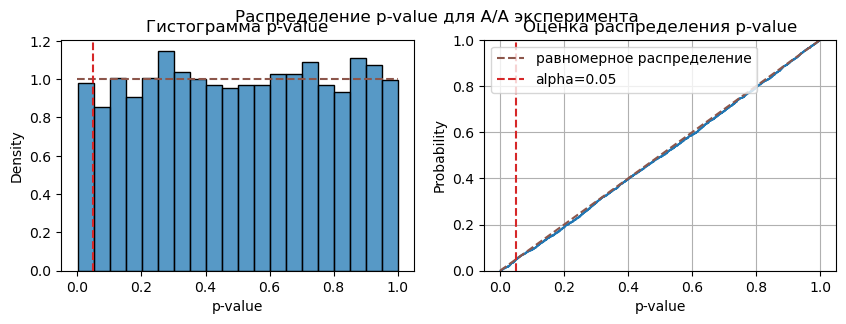

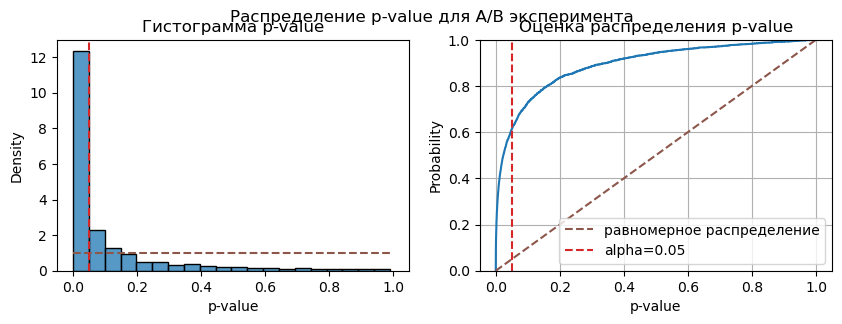

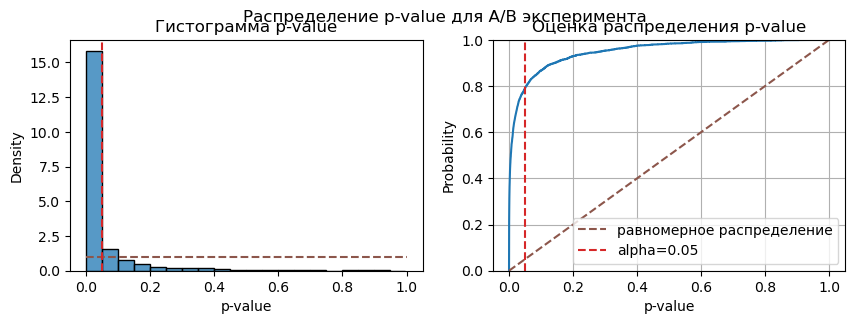

In [350]:
plot_pvalue_ecdf(pvalues_aa, title="Распределение p-value для A/A эксперимента") 
plot_pvalue_ecdf(pvalues_ab, title="Распределение p-value для A/B эксперимента") 
plot_pvalue_ecdf(pvalues_ab2, title="Распределение p-value для A/B эксперимента") 

In [293]:
# Дельта метод
values = control_A['cnt_watch']
visible_values = control_A['cnt_visible']
sample_size = len(control_A['cnt_watch']) 


pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0240)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0300)  


print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0503
  доверительный интервал = [0.0425, 0.0582]
оценка вероятности ошибки II рода (эффект 1) = 0.4040
  доверительный интервал = [0.3864, 0.4216]
оценка вероятности ошибки II рода (эффект 2) = 0.2103
  доверительный интервал = [0.1957, 0.2249]


#### watched rate

In [357]:
sample_size = len(control_A['cnt_watched'])
std = control_A['cnt_watched'].std()
mu_control = control_A['cnt_watched'].mean()

calculate_mde(sample_size, std, mu_control, alpha=0.05, beta=0.2)

mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

MDE для выборки размером 44102 в абсолютных единицах = 0.305
MDE для выборки размером 44102 в относительных единицах = 2.68%


In [362]:
# Линеарилизация
values = control_A['cnt_watched'].values  
visible_values = control_A['cnt_visible'].values
sample_size = len(control_A['cnt_watched'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0268)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0320) 

print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0497
  доверительный интервал = [0.0419, 0.0574]
оценка вероятности ошибки II рода (эффект 1) = 0.3577
  доверительный интервал = [0.3405, 0.3748]
оценка вероятности ошибки II рода (эффект 2) = 0.2030
  доверительный интервал = [0.1886, 0.2174]


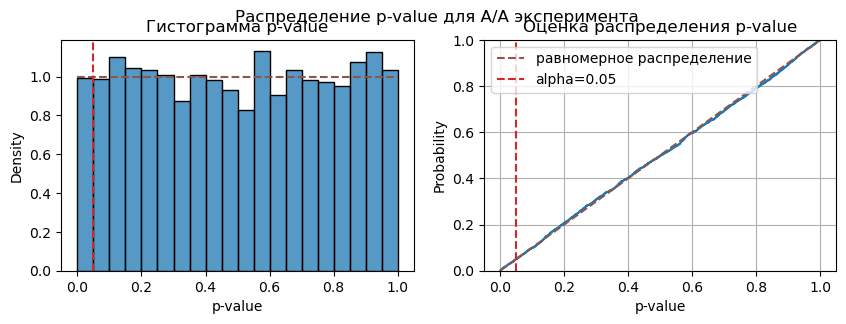

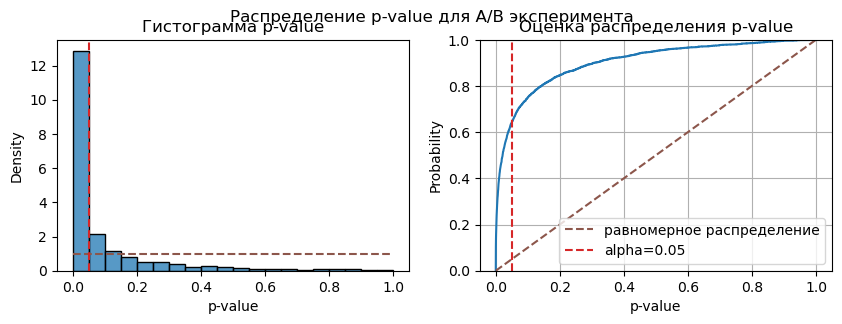

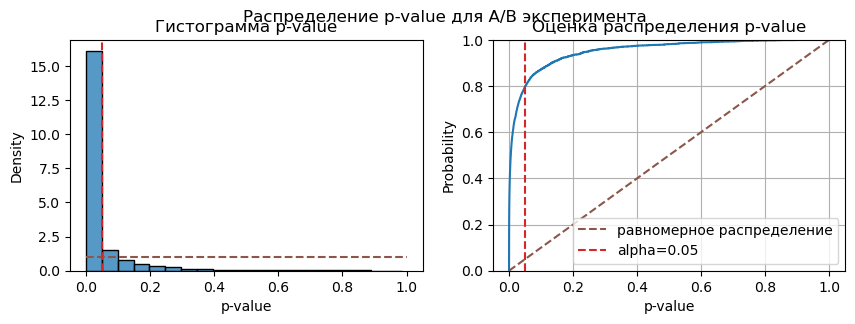

In [363]:
plot_pvalue_ecdf(pvalues_aa, title="Распределение p-value для A/A эксперимента") 
plot_pvalue_ecdf(pvalues_ab, title="Распределение p-value для A/B эксперимента") 
plot_pvalue_ecdf(pvalues_ab2, title="Распределение p-value для A/B эксперимента") 

In [297]:
# Дельта метод
values = control_A['cnt_watched'].values  
visible_values = control_A['cnt_visible'].values
sample_size = len(control_A['cnt_watched'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0268)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.0320) 

print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0543
  доверительный интервал = [0.0462, 0.0624]
оценка вероятности ошибки II рода (эффект 1) = 0.3793
  доверительный интервал = [0.3620, 0.3967]
оценка вероятности ошибки II рода (эффект 2) = 0.1960
  доверительный интервал = [0.1818, 0.2102]


#### Like_rate

In [364]:
sample_size = len(control_A['cnt_like'])
std = control_A['cnt_like'].std()
mu_control = control_A['cnt_like'].mean()

calculate_mde(sample_size, std, mu_control, alpha=0.05, beta=0.2)

mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

MDE для выборки размером 44102 в абсолютных единицах = 0.041
MDE для выборки размером 44102 в относительных единицах = 14.48%


In [369]:
# Линеарилизация
values = control_A['cnt_like'].values  
visible_values = control_A['cnt_like'].values
sample_size = len(control_A['cnt_like'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.14)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.21) 

print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0477
  доверительный интервал = [0.0400, 0.0553]
оценка вероятности ошибки II рода (эффект 1) = 0.5437
  доверительный интервал = [0.5258, 0.5615]
оценка вероятности ошибки II рода (эффект 2) = 0.2097
  доверительный интервал = [0.1951, 0.2242]


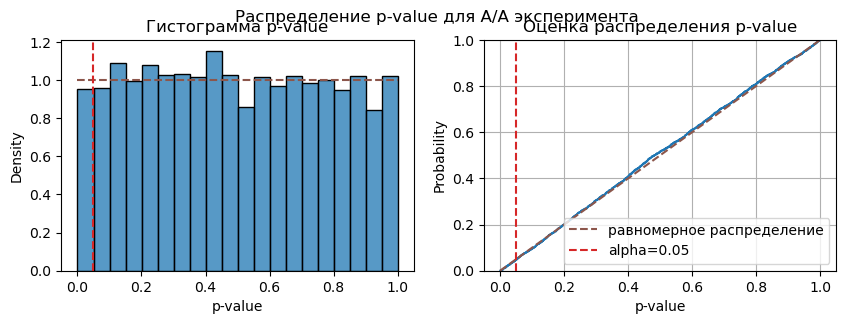

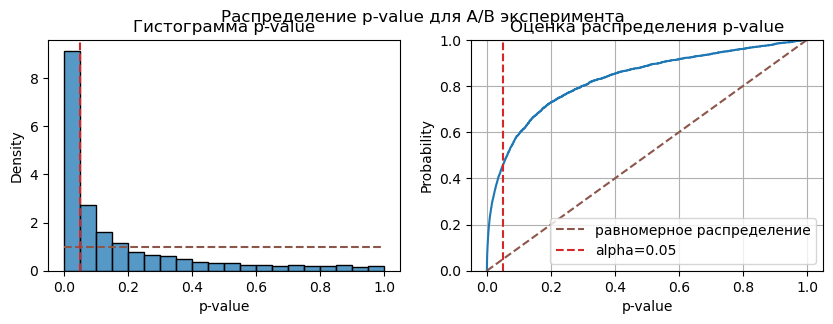

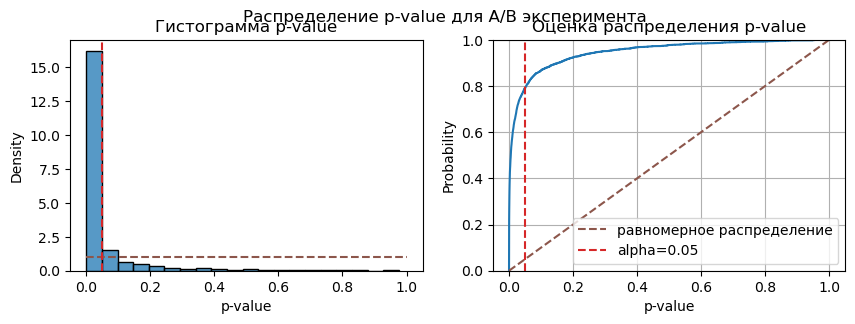

In [370]:
plot_pvalue_ecdf(pvalues_aa, title="Распределение p-value для A/A эксперимента") 
plot_pvalue_ecdf(pvalues_ab, title="Распределение p-value для A/B эксперимента") 
plot_pvalue_ecdf(pvalues_ab2, title="Распределение p-value для A/B эксперимента") 

In [300]:
# Дельта метод
values = control_A['cnt_like'].values  
visible_values = control_A['cnt_like'].values
sample_size = len(control_A['cnt_like'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.14)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.22) 

print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0530
  доверительный интервал = [0.0450, 0.0610]
оценка вероятности ошибки II рода (эффект 1) = 0.5353
  доверительный интервал = [0.5175, 0.5532]
оценка вероятности ошибки II рода (эффект 2) = 0.2097
  доверительный интервал = [0.1951, 0.2242]


#### Comment rate

In [371]:
sample_size = len(control_A['cnt_comment'])
std = control_A['cnt_comment'].std()
mu_control = control_A['cnt_comment'].mean()

calculate_mde(sample_size, std, mu_control, alpha=0.05, beta=0.2)

mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

MDE для выборки размером 44102 в абсолютных единицах = 0.004
MDE для выборки размером 44102 в относительных единицах = 23.02%


In [373]:
# Линеарилизация
values = control_A['cnt_comment'].values  
visible_values = control_A['cnt_comment'].values
sample_size = len(control_A['cnt_comment'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.23)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.35) 

print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0557
  доверительный интервал = [0.0475, 0.0639]
оценка вероятности ошибки II рода (эффект 1) = 0.5293
  доверительный интервал = [0.5115, 0.5472]
оценка вероятности ошибки II рода (эффект 2) = 0.2107
  доверительный интервал = [0.1961, 0.2253]


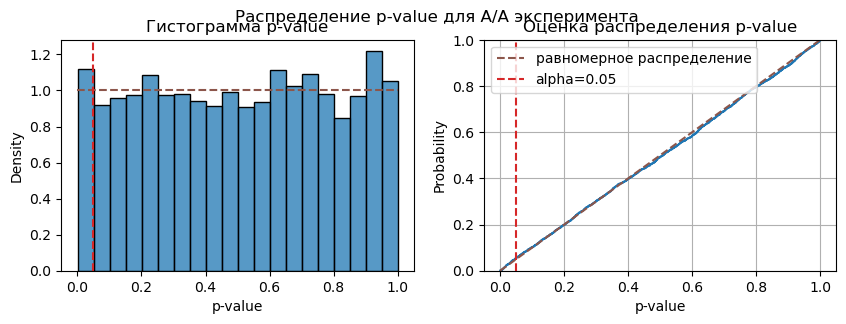

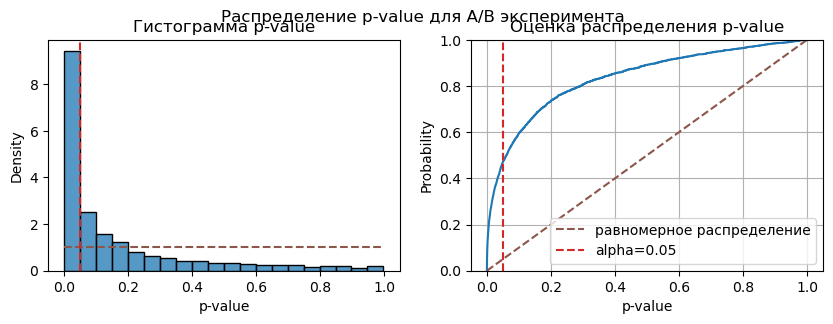

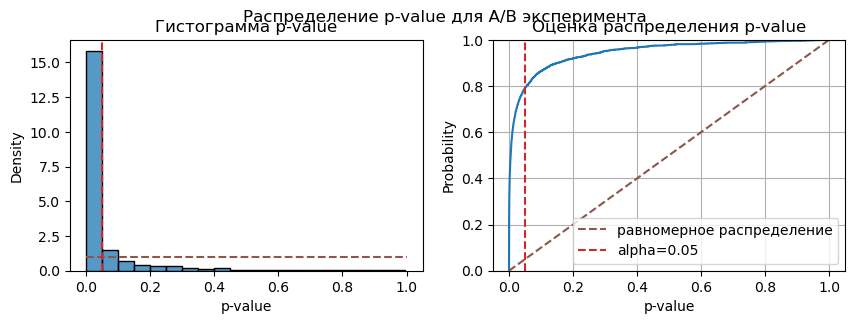

In [374]:
plot_pvalue_ecdf(pvalues_aa, title="Распределение p-value для A/A эксперимента") 
plot_pvalue_ecdf(pvalues_ab, title="Распределение p-value для A/B эксперимента") 
plot_pvalue_ecdf(pvalues_ab2, title="Распределение p-value для A/B эксперимента") 

In [315]:
# Дельта метод
values = control_A['cnt_comment'].values  
visible_values = control_A['cnt_comment'].values
sample_size = len(control_A['cnt_comment'])  

pvalues_aa = simulation(values, visible_values, int(sample_size*1.05), effect=0)
pvalues_ab = simulation(values, visible_values, int(sample_size*1.05), effect = 0.23)
pvalues_ab2 = simulation(values, visible_values, int(sample_size*1.05), effect = 0.35) 

print_estimated_errors(pvalues_aa, pvalues_ab, pvalues_ab2, alpha=0.05)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

оценка вероятности ошибки I рода = 0.0610
  доверительный интервал = [0.0524, 0.0696]
оценка вероятности ошибки II рода (эффект 1) = 0.5150
  доверительный интервал = [0.4971, 0.5329]
оценка вероятности ошибки II рода (эффект 2) = 0.1970
  доверительный интервал = [0.1828, 0.2112]


#### Retention

In [376]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention=df_wo_outlier[df_wo_outlier['d_0'].notna()]

In [377]:
grouped_df = df_retention.groupby('experiment_group').agg({'appmetrica_device_id':'count'})
total_count = grouped_df['appmetrica_device_id'].sum()
grouped_df.loc['Total'] = [total_count]

In [379]:
control_A_retention=df_retention[df_retention['experiment_group']=='honorary_viewer_start_A']
control_D_retention=df_retention[df_retention['experiment_group']=='honorary_viewer_start_D']

test_B_retention=df_retention[df_retention['experiment_group']=='honorary_viewer_start_B']
test_C_retention=df_retention[df_retention['experiment_group']=='honorary_viewer_start_C']

In [380]:
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest

In [384]:
metrics = df_retention.groupby('experiment_group', as_index= False).agg({'d_1':'sum', 'd_0':'sum'})
metrics['conv'] = metrics['d_1'] / metrics['d_0'] * 100

print('z-test AB групп',ztest(control_A_retention['d_1'],control_A_retention['d_1'])) 


z-test AB групп (0.0, 1.0)


In [390]:
sample_size = len(control_A_retention['d_1'])
std =control_A_retention['d_1'].std()
mu_control = control_A_retention['d_1'].mean()

calculate_mde(sample_size, std, mu_control, alpha=0.05, beta=0.2)

mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

MDE для выборки размером 34159 в абсолютных единицах = 0.01
MDE для выборки размером 34159 в относительных единицах = 2.76%


In [407]:
import statsmodels.api as sm

num_simulations = 1000
effect = 0.0276

# Reset error counters
type_1_errors = 0
type_2_errors = 0

for _ in range(num_simulations):
    
    # AA test
    sample_A1 = np.random.choice(control_A_retention['d_1'], size=len(control_A_retention), replace=True)
    sample_A2 = np.random.choice(control_A_retention['d_1'], size=len(control_A_retention), replace=True)
    z_stat, p_val = sm.stats.ztest(sample_A1, sample_A2)
    
    if p_val < 0.05:
        type_1_errors += 1
        
    # AB test
    sample_A2_effect = sample_A2 * (1 + effect)
    z_stat, p_val = sm.stats.ztest(sample_A1, sample_A2_effect)
    
    if p_val > 0.05:
        type_2_errors += 1

type_1_error_rate = type_1_errors / num_simulations
type_2_error_rate = type_2_errors / num_simulations

print(f'Ошибка 2 рода {type_1_error_rate}')
print(f'Ошибка 2 рода {type_2_error_rate}')


Ошибка 2 рода 0.046
Ошибка 2 рода 0.215


#### AARRR

In [409]:
df_activation=df_wo_outlier[df_wo_outlier['users_new_viewers']==1]
control_A_activation=df_activation[df_activation['experiment_group']=='honorary_viewer_start_A']
test_B_activation=df_activation[df_activation['experiment_group']=='honorary_viewer_start_B']
test_C_activation=df_activation[df_activation['experiment_group']=='honorary_viewer_start_C']
control_D_activation=df_activation[df_activation['experiment_group']=='honorary_viewer_start_D']


In [411]:
sample_size = len(control_A_activation['users_new_viewers_activated'])
std =control_A_activation['users_new_viewers_activated'].std()
mu_control = control_A_activation['users_new_viewers_activated'].mean()

calculate_mde(sample_size, std, mu_control, alpha=0.05, beta=0.2)

mde_absolute, mde_relative = calculate_mde(sample_size, std, mu_control, alpha, beta)
print(f'MDE для выборки размером {sample_size} в абсолютных единицах = {round(mde_absolute, 3)}')
print(f'MDE для выборки размером {sample_size} в относительных единицах = {mde_relative:.2f}%')

MDE для выборки размером 25944 в абсолютных единицах = 0.01
MDE для выборки размером 25944 в относительных единицах = 1.34%


In [413]:
import statsmodels.api as sm

num_simulations = 1000
effect = 0.0134

# Reset error counters
type_1_errors = 0
type_2_errors = 0

for _ in range(num_simulations):
    
    # AA test
    sample_A1 = np.random.choice(control_A_activation['users_new_viewers_activated'], size=len(control_A_activation), replace=True)
    sample_A2 = np.random.choice(control_A_activation['users_new_viewers_activated'], size=len(control_A_activation), replace=True)
    z_stat, p_val = sm.stats.ztest(sample_A1, sample_A2)
    
    if p_val < 0.05:
        type_1_errors += 1
        
    # AB test
    sample_A2_effect = sample_A2 * (1 + effect)
    z_stat, p_val = sm.stats.ztest(sample_A1, sample_A2_effect)
    
    if p_val > 0.05:
        type_2_errors += 1

type_1_error_rate = type_1_errors / num_simulations
type_2_error_rate = type_2_errors / num_simulations

print(f'Ошибка 2 рода {type_1_error_rate}')
print(f'Ошибка 2 рода {type_2_error_rate}')


Ошибка 2 рода 0.054
Ошибка 2 рода 0.207


#### Выводы

При проведнии АБ экспериментов можно заметить, что даже при введении эффекта равной размеру MDE эта разница не всегда является статистически значимой. Это может говорит нам о том, что введенный нами эффект (MDE) на самом деле является слишком маленьким, чтобы быть обнаруженным в этом конкретном эксперименте, особенно учитывая уровень шума или изменчивость в данных. 

Ответ в формуле для расчета MDE - в формуле используются не точные значения стандартных отклонений, а их оценки, которые имеют погрешность и могут немного искажать результат.


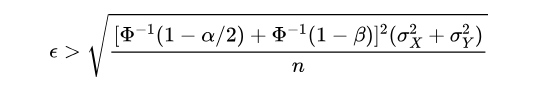